(sec-distr-coniugate)=
# Distribuzioni coniugate

Obiettivo di questo Capitolo è fornire un esempio di derivazione della distribuzione a posteriori scegliendo quale distribuzione a priori una distribuzione coniugata. Esamineremo qui il lo schema beta-binomiale. (Il codice python che uso è messo a disposizione da [PyMC](https://github.com/pymc-devs/pymc-resources/blob/main/Bayes_Rules/Chapter_3_The_Beta-Binomial_Bayesian_Model.ipynb)).

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats
from scipy import integrate
import numpy as np
import pymc as pm
from scipy.stats import beta
from scipy.constants import golden

In [6]:
%matplotlib inline
sns.set_theme()
sns.set_palette("colorblind")
plt.rc('figure', figsize=(5.0, 5.0/golden))
SEED = 42
rng = np.random.default_rng(SEED)

## Lo schema beta-binomiale

Esiste una particolare classe di distribuzioni a priori, dette distribuzioni a priori coniugate al modello, che godono di un'importante proprietà: se la distribuzione iniziale appartiene a tale classe, anche la distribuzione finale vi appartiene, cioé ha la stessa forma funzionale, e l'aggiornamento della fiducia si riduce alla modifica dei parametri della distribuzione a priori. Ad esempio, se la distribuzione a priori è una Beta e la verosimiglianza è binomiale, allora la distribuzione a posteriori sarà anch'essa una distribuzione Beta.

Da un punto di vista matematico, le distribuzioni a priori coniugate sono la scelta più conveniente in quanto consentono di calcolare analiticamente la distribuzione a posteriori con "carta e penna", senza la necessità di ricorrere a calcoli complessi. Da una prospettiva computazionale moderna, però, le distribuzioni a priori coniugate generalmente non sono migliori delle alternative, dato che i moderni metodi computazionali consentono di eseguire l'inferenza praticamente con qualsiasi scelta delle distribuzioni a priori, e non solo con le distribuzioni a priori che risultano matematicamente convenienti. Tuttavia, le famiglie coniugate offronto un utile ausilio didattico nello studio dell'inferenza bayesiana. Questo è il motivo per cui le esamineremo qui. Nello specifico, esamineremo quello che viene chiamato lo schema beta-binomiale.

Per fare un esempio concreto, consideriamo nuovamente i dati di {cite:t}`zetsche_2019future`: nel campione di 30 partecipanti clinici le aspettative future di 23 partecipanti risultano negativamente distorte mentre quelle di 7 partecipanti risultano positivamente distorte. Nel seguito, indicheremo con $\theta$ la probabilità che le aspettative di un paziente clinico siano distorte negativamente. Ci poniamo il problema di ottenere una stima a posteriori di $\theta$ avendo osservato 23 "successi" in 30 prove. I dati osservati ($y = 23$) possono essere considerati la manifestazione di una variabile casuale Bernoulliana, dunque la verosimiglianza è binomiale. In tali circostanze, se viene scelta una distribuzione a priori Beta, allora anche la distribuzione a posteriori sarà una Beta.

### La distribuzione a priori

È possibile esprimere diverse credenze iniziali rispetto a $\theta$ mediante la distribuzione Beta. Ad esempio, la scelta di una $Beta(\alpha = 4, \beta = 4)$ quale distribuzione a priori per il parametro $\theta$ corrisponde alla credenza a priori che associa all'evento "presenza di una aspettativa futura distorta negativamente" una grande incertezza: il valore 0.5 è il valore di $\theta$ più plausibile, ma anche gli altri valori del parametro (tranne gli estremi) sono ritenuti piuttosto plausibili. Questa distribuzione a priori esprime la credenza che sia egualmente probabile per un'aspettativa futura essere distorta negativamente o positivamente.

In [7]:
def plot_beta(alpha, beta, mean=False, mode=False):
    theta = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(theta, alpha, beta)
    plt.plot(theta, p_theta_given_y, lw=2, color="k")
    plt.xlabel(r"$\pi$")
    plt.ylabel("$f(x)$")

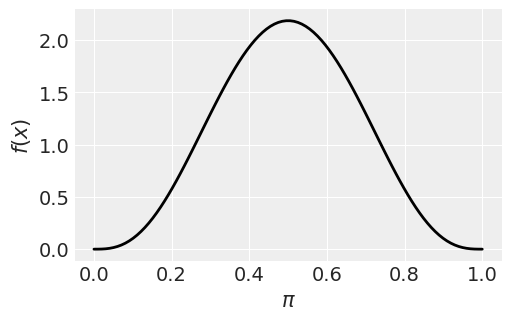

In [8]:
# Plot the Beta(45, 55) prior
plot_beta(4, 4)

Un sommario della distribuzione $Beta(4, 4)$ si ottiene usando la funzione seguente:

In [9]:
def summarize_beta(alpha, beta):
    r"""Summarize a Beta Model for \eqn{\pi}

    @param alpha,beta positive shape parameters of the Beta model

    Return Pandas Series with summary
    """

    mean = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    sd = np.sqrt(var)

    if alpha < 1 and beta < 1:
        mode = "0 and 1"
    elif alpha <= 1 and beta > 1:
        mode = 0
    elif alpha > 1 and beta < 1:
        mode = 1
    else:
        mode = (alpha - 1) / (alpha + beta - 2)
    return pd.Series({"mean": mean, "mode": mode, "var": var, "sd": sd})

In [10]:
summarize_beta(4, 4)

mean    0.500000
mode    0.500000
var     0.027778
sd      0.166667
dtype: float64

Possiamo quantificare la nostra incertezza calcolando, con un grado di fiducia del 95%, la regione nella quale, in base a tale credenza a priori, si trova il valore del parametro. Per ottenere tale intervallo di credibilità a priori, usiamo la funzione `beta.ppf` di `scipy.stats`. 

In [13]:
li = beta.ppf(0.025, 4, 4)
ls = beta.ppf(0.975, 4, 4)
list([li, ls])

[0.184051567640083, 0.8159484323599169]

Se poniamo $\alpha=10$ e $\beta=10$, anche questa scelta descrive una credenza a priori per la quale è egualmente probabile osservare un'aspettativa futura distorta negativamente o positivamente.

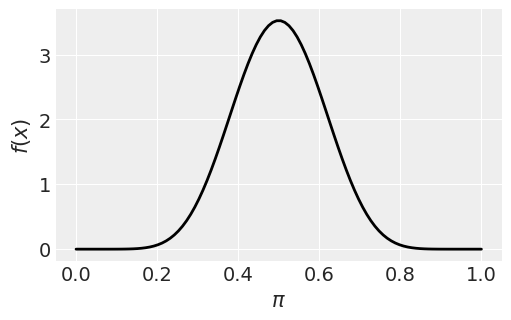

In [12]:
plot_beta(10, 10)

Tuttavia, in questo caso la nostra certezza a priori sul valore del parametro è maggiore, come indicato dall'intervallo di ordine 0.95.

In [14]:
li = beta.ppf(0.025, 10, 2)
ls = beta.ppf(0.975, 10, 2)
list([li, ls])

[0.5872200830116173, 0.9771688017000404]

Quale distribuzione a priori dobbiamo scegliere? In un problema concreto di analisi dei dati, la scelta della distribuzione a priori dipende dalle credenze a priori che vogliamo includere nell'analisi dei dati. Se non abbiamo alcuna informazione a priori, allora è possibile usare $\alpha=1$ e $\beta=1$, che corrisponde ad una distribuzione a priori uniforme. Ma l'uso di distribuzioni a priori uniformi è sconsigliato per vari motivi, inclusa l'instabilità numerica della stima dei parametri. In tali circostanze sarebbe preferibile usare una distribuzione a priori debolmente informativa, come una $Beta(2, 2)$.

Nella discussione presente, quale distribuzione a priori useremo una $Beta(2, 10)$.

$$
p(\theta) = \frac{\Gamma(12)}{\Gamma(2)\Gamma(10)}\theta^{2-1} (1-\theta)^{10-1}.
$$

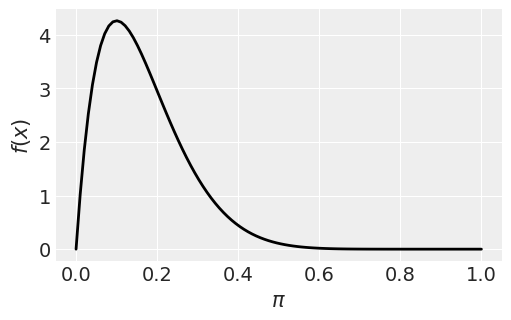

In [15]:
plot_beta(2, 10)

Tale distribuzione a priori è del tutto inappropriata per i dati di {cite:t}`zetsche_2019future`. La $Beta(2, 10)$ esprime la credenza che $\theta < 0.5$, con il valore più plausibile pari a cicrca 0.1. Ma non c'è motivo di pensare, a priori, che, per questa popolazione, vi sia una bassa probabilità di un'aspettativa futura distorta negativamente -- piuttosto è vero il contrario. La $Beta(2, 10)$ verrà usata qui solo per mostrare che effetto  ha una tale scelta sulla distribuzione a posteriori.

### La distribuzione a posteriori

Una volta scelta una distribuzione a priori di tipo Beta, i cui parametri rispecchiano le nostre credenze iniziali su $\theta$, la distribuzione a posteriori viene specificata dalla formula di Bayes:

$$
\text{distribuzione a posteriori} = \frac{\text{verosimiglianza}\cdot\text{distribuzione a priori}}{\text{verosimiglianza marginale}}.
$$

Per i dati presenti la verosimiglianza è binomiale per cui abbiamo

$$
p(\theta \mid n=30, y=23) = \frac{\Big[\binom{30}{23}\theta^{23}(1-\theta)^{30-23}\Big]\Big[\frac{\Gamma(12)}{\Gamma(2)\Gamma(10)}\theta^{2-1} (1-\theta)^{10-1}\Big]}{p(y = 23)},
$$

laddove $p(y = 23)$, ovvero la verosimiglianza marginale, è una costante di normalizzazione.

Riscriviamo l'equazione precedente in termini più generali:

$$
p(\theta \mid n, y) = \frac{\Big[\binom{n}{y}\theta^{y}(1-\theta)^{n-y}\Big]\Big[\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1} (1-\theta)^{b-1}\Big]}{p(y)}.
$$

Raccogliendo tutte le costanti otteniamo:

$$
p(\theta \mid n, y) =\left[\frac{\binom{n}{y}\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}}{p(y)}\right] \theta^{y}(1-\theta)^{n-y}\theta^{a-1} (1-\theta)^{b-1}.
$$

Se ignoriamo il termine costante all'interno della parentesi quadra il termine di destra dell'equazione precedente identifica il *kernel* della distribuzione a posteriori e corrisponde ad una Beta *non normalizzata* di parametri $a + y$ e $b + n - y$:

$$
\begin{align}
p(\theta \mid n, y) &\propto \theta^{y}(1-\theta)^{n-y}\theta^{a-1} (1-\theta)^{b-1},\notag\\
&\propto \theta^{a+y-1}(1-\theta)^{b+n-y-1}.
\end{align}
$$

Per ottenere una distribuzione di densità, dobbiamo aggiungere una costante di normalizzazione al kernel della distribuzione a posteriori. In base alla definizione della distribuzione Beta, ed essendo $a' = a+y$ e $b' = b+n-y$, tale costante di normalizzazione è uguale a

$$
\frac{\Gamma(a'+b')}{\Gamma(a')\Gamma(b')} = \frac{\Gamma(a+b+n)}{\Gamma(a+y)\Gamma(b+n-y)}.
$$

Possiamo dunque concludere, nel caso dello schema beta-binomiale, che la distribuzione a posteriori è una $Beta(a+y, b+n-y)$:

$$
Beta(a+y, b+n-y) = \frac{\Gamma(a+b+n)}{\Gamma(a+y)\Gamma(b+n-y)} \theta^{a+y-1}(1-\theta)^{b+n-y-1}.
$$

In sintesi, per i dati in discussione, moltiplicando verosimiglianza $Bin(n = 30, y = 23 \mid \theta)$ per la la distribuzione a priori $\theta \sim Beta(2, 10)$ e dividendo per la costante di normalizzazione, si ottiene la distribuzione a posteriori $p(\theta \mid n, y) \sim Beta(25, 17)$.

Questo è un esempio di analisi coniugata. La presente combinazione di verosimiglianza e distribuzione a priori è chiamata caso coniugato *beta-binomiale* ed è descritta dal seguente teorema.

```{admonition} Teorema
Sia data la funzione di verosimiglianza $Bin(n, y \mid \theta)$ e sia $Beta(\alpha, \beta)$ una distribuzione a priori. In tali circostanze, la distribuzione a posteriori del parametro $\theta$ sarà una distribuzione $Beta(\alpha + y, \beta + n - y)$.
```

È facile calcolare il valore atteso a posteriori di $\theta$. Essendo $\mathbb{E}[Beta(\alpha, \beta)] = \frac{\alpha}{\alpha + \beta}$, il risultato cercato diventa

$$
\mathbb{E}_{\text{post}} [\mathrm{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta +n}.
$$ (eq-ev-post-beta-bin-1)

Per fare un esercizio, rappresentiamo in maniera grafica e si descriva in forma numerica l'aggiornamento bayesiano beta-binomiale per i dati di {cite:t}`zetsche_2019future`. Assumiamo una distribuzione a priori $Beta(2, 10)$.
```

Per i dati in questione, l'aggiornamento bayesiano può essere rappresentato in forma grafica usando la funzione `plot_beta_binomial()` del pacchetto `bayesrules`:

In [16]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ, likelihood / scale_factor, lw=4, color="b", label="likelihood scaled", alpha=0.2
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()

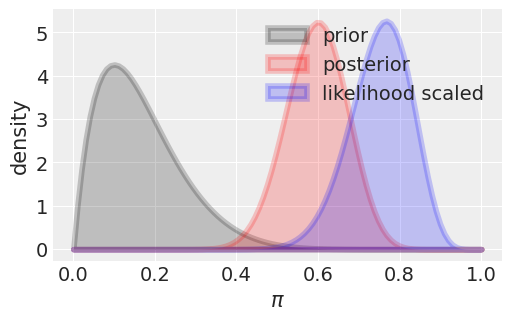

In [17]:
plot_beta_binomial(alpha=2, beta=10, y=23, n=30)

Facciamo un altro esercizio. Per i dati di {cite:t}`zetsche_2019future`, troviamo la media, la moda, la deviazione standard della distribuzione a posteriori di $\theta$. Troviamo inoltre l'intervallo di credibilità a posteriori del 95% per il parametro $\theta$.

L'intervallo di credibilità a posteriori del 95% per il parametro $\theta$ si trova usando il Teorema descritto sopra.

In [18]:
li = stats.beta.ppf(0.025, 25, 17)
ls = stats.beta.ppf(0.975, 25, 17)
list([li, ls])

[0.44504782337068916, 0.7368320053113375]

La media della distribuzione a posteriori si trova con l'eq. {eq}`eq-ev-post-beta-bin-1`. 

In [44]:
25 / (25 + 17)

0.5952380952380952

La moda della distribuzione a posteriori si trova usando le proprietà della distribuzione Beta.

In [45]:
(25 - 1) / (25 + 17 - 2)

0.6

La deviazione standard della distribuzione a posteriori si trova usando le proprietà della distribuzione Beta.

In [19]:
def var_beta(a, b):
    res = (a * b) / ((a + b)**2 * (a + b + 1))
    return res

alpha = 25
beta = 17
np.sqrt(var_beta(alpha, beta))

0.07485329919488247

Confermo i risultati:

In [20]:
summarize_beta(25, 17)

mean    0.595238
mode    0.600000
var     0.005603
sd      0.074853
dtype: float64

Consideriamo un altro esercizio. Troviamo i parametri e le proprietà della distribuzione a posteriori del parametro $\theta$ per i dati dell'esempio relativo alla ricerca di Stanley Milgram discussa da {cite:t}`Johnson2022bayesrules`.

Nel 1963, Stanley Milgram presentò una ricerca sulla propensione delle persone a obbedire agli ordini di figure di autorità, anche quando tali ordini possono danneggiare altre persone {cite:t}`milgram1963behavioral`. Nell'articolo, Milgram descrive lo studio come

> consist\[ing\] of ordering a naive subject to administer electric shock to a victim. A simulated shock generator is used, with 30 clearly marked voltage levels that range from IS to 450 volts. The instrument bears verbal designations that range from Slight Shock to Danger: Severe Shock. The responses of the victim, who is a trained confederate of the experimenter, are standardized. The orders to administer shocks are given to the naive subject in the context of a "learning experiment" ostensibly set up to study the effects of punishment on memory. As the experiment proceeds the naive subject is commanded to administer increasingly more intense shocks to the victim, even to the point of reaching the level marked Danger: Severe Shock.

All'insaputa del partecipante, gli shock elettrici erano falsi e l'attore stava solo fingendo di provare il dolore dello shock.

{cite:t}`Johnson2022bayesrules` fanno inferenza sui risultati dello studio di Milgram mediante il modello Beta-Binomiale. Il parametro di interesse è $\theta$, la probabiltà che una persona obbedisca all'autorità (in questo caso, somministrando lo shock più severo), anche se ciò significa recare danno ad altri. {cite:t}`Johnson2022bayesrules` ipotizzano che, prima di raccogliere dati, le credenze di Milgram relative a $\theta$ possano essere rappresentate mediante una $Beta(1, 10)$. Sia $y = 26$ il numero di soggetti che, sui 40 partecipanti allo studio, aveva accettato di infliggere lo shock più severo. Assumendo a ogni partecipante si comporti indipendentemente dagli altri, possiamo modellare la dipendenza di $y$ da $\theta$ usando la distribuzione binomiale. Giungiamo dunque al seguente modello bayesiano Beta-Binomiale:

$$
\begin{align}
y \mid \theta & \sim \text{Bin}(n = 40, \theta) \notag\\
\theta & \sim \text{Beta}(1, 10) \; . \notag
\end{align}
$$

Il processo di aggiornamento bayesiano è descritto dalla figura ottenuta con la funzione `bayesrules::plot_beta_binomial()`.

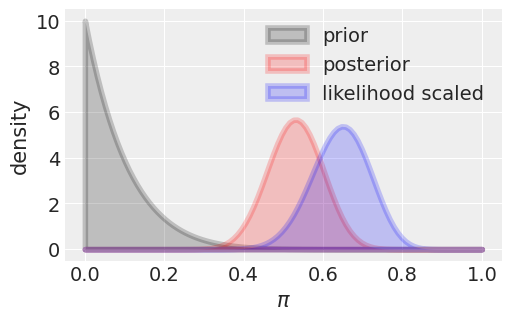

In [21]:
plot_beta_binomial(alpha=1, beta=10, y=26, n=40)

## Inferenza bayesiana con distribuzioni a priori continue

L'inferenza bayesiane sulla proporzione $\theta$ si basa su vari riepiloghi della distribuzione a posteriori Beta. Il riepilogo che si calcola dalla distribuzione a posteriori dipende dal tipo di inferenza. Consideriamo qui su due tipi di inferenza:

1.  problemi in cui si è interessati a valutare la plausibilità che il parametro assuma valori contenuti in un dato intervallo di valori,
2.  stime dell'intervallo che contiene il parametro ad un dato livello di probabilità soggettiva.

### Verifica di ipotesi bayesiana

Nell'esempio in discussione sui dati di {cite:t}`zetsche_2019future`, la nostra credenza a posteriori relativa a $\theta$ (ovvero, la probabilità che l'aspettativa dell'umore futuro sia distorta negativamente) è descritta da una distribuzione Beta(25,17). Una volta definita la distribuzione a posteriori, ci possiamo porre altre domande. Per esempio: qual è la probabilità che $\theta$ sia maggiore di 0.5?

Una risposta a questa domanda si può trovare usando nel modo seguente.

In [52]:
1 - stats.beta.cdf(0.5, 25, 17)

0.8944882011955997

Questo calcolo può anche essere svolto mediante simulazione. Dato che conosciamo la distribuzione target, è possibile ricavare un campione casuale di osservazioni da una tale distribuzione per poi riassumere il campione in modo tale da trovare $\theta > 0.5$.

In [53]:
nsim = 1000000
theta_samples = np.random.beta(25,17,size=nsim)
sum(list(theta_samples > 0.5)) / len(theta_samples)

0.895085

Il risultato della simulazione è molto simile a quello ottenuto in precedenza.

### Intervalli di credibilità

Un secondo tipo di inferenza bayesiana è quella che ci porta a costruire gli intervalli di credibilità. Un intervallo di credibilità di ordine $a \in [0, 1]$ è l'intervallo di valori che contiene una proporzione della distribuzione a posteriori pari ad $a$.

La funzione `hdi` del modulo `pymc` consente di calcolare l'intervallo di credibilità che lascia la stessa probabilità nelle due code. Per esempio, l'intervallo di credibilità all'89% per la distribuzione a posteriori dell'esempio relativo ai dati di {cite:t}`zetsche_2019future` è il seguente.

In [54]:
pm.hdi(theta_samples)

array([0.45427697, 0.73465101])

## Principali distribuzioni coniugate

Esistono altre combinazioni di verosimiglianza e distribuzione a priori le quali producono una distribuzione a posteriori che ha la stessa densità della distribuzione a priori. Sono elencate qui sotto le più note coniugazioni tra modelli statistici e distribuzioni a priori.

-   Per il modello Normale-Normale $\mathcal{N}(\mu, \sigma^2_0)$, la distribizione iniziale è $\mathcal{N}(\mu_0, \tau^2)$ e la distribuzione finale è $\mathcal{N}\left(\frac{\mu_0\sigma^2 + \bar{y}n\tau^2}{\sigma^2 + n\tau^2}, \frac{\sigma^2\tau^2}{\sigma^2 + n\tau^2} \right)$.
-   Per il modello Poisson-gamma $\text{Po}(\theta)$, la distribizione iniziale è $\Gamma(\lambda, \delta)$ e la distribuzione finale è $\Gamma(\lambda + n \bar{y}, \delta +n)$.
-   Per il modello esponenziale $\text{Exp}(\theta)$, la distribizione iniziale è $\Gamma(\lambda, \delta)$ e la distribuzione finale è $\Gamma(\lambda + n, \delta +n\bar{y})$.
-   Per il modello uniforme-Pareto $\text{U}(0, \theta)$, la distribizione iniziale è $\text{Pa}(\alpha, \varepsilon)$ e la distribuzione finale è $\text{Pa}(\alpha + n, \max(y_{(n)}, \varepsilon))$.

## Commenti e considerazioni finali 

Lo scopo di questo Capitolo è stato quello di mostrare come sia possibile integrare le conoscenze a priori (espresse nei termini di una distribuzione a priori) con le evidenze fornite dai dati (espresse nei termini della funzione di verosimiglianza), così da determinare, mediante il teorema di Bayes, una distribuzione a posteriori, la quale condensa l'incertezza che abbiamo sul parametro sconosciuto $\theta$. Per illustrare tale problema, abbiamo considerato una situazione nella quale $\theta$ corrisponde alla probabilità di successo in una sequenza di prove Bernoulliane. In tali circostanze è ragionevole esprimere le credenze a priori mediante la densità Beta, con opportuni parametri. L'inferenza rispetto a $\theta$ può essere dunque svolta utilizzando una distribuzione a priori Beta e una verosimiglianza binomiale. In tali circostanze, la distribuzione a posteriori diventa essa stessa una distribuzione Beta. Questo è il cosiddetto schema beta-binomiale. Dato che utilizza una distribuzione a priori coniugata, lo schema beta-binomiale rende possibile la determinazione analitica dei parametri della distribuzione a posteriori.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w